In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import torch

from src.models.model_diff_modular import ModularDiffModel
from src.models.model_diff_adv import AdvDiffModel
from src.models.model_diff_task import TaskDiffModel

from analysis_utils import get_sparsity_info, get_viz_data, get_nonzero_dicts

In [3]:
output_folder = "charts"
n_seeds = 5

In [4]:
folder = "/share/home/lukash/pan16/bertl4/cp_init/task-baseline-bert_uncased_L-4_H-256_A-4-64-2e-05-seed0.pt/cp"
experiment_name = "adverserial-diff_pruning_0.1-bert_uncased_L-4_H-256_A-4-64-2e-05-cp_init-weighted_loss_prot-gender-seed{}.pt"
# experiment_name = "adverserial-diff_pruning_0.1-a_samples_3-bert_uncased_L-4_H-256_A-4-64-2e-05-cp_init-weighted_loss_prot-gender-seed{}.pt"
model_cls = AdvDiffModel

In [5]:
model_dicts, model_layer_dicts, model_module_dicts = get_sparsity_info(folder, experiment_name, model_cls)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing B

In [6]:
base_dict, layer_dict, module_dict, emb_dict, layer_list = get_viz_data(model_dicts, model_layer_dicts, model_module_dicts)

In [7]:
n_layers = len(layer_list)
n_modules = len(layer_list[0])
module_names = list(layer_list[0].keys())

colors = [plt.get_cmap('Blues'), plt.get_cmap('Oranges')]
color_fn = lambda x: abs(x-1)-0.2

width = 1
spacing = width / 4
y_coords = np.arange(n_layers)
y_coords_adj = np.concatenate([
    y_coords,
    [y_coords[-1] + width, y_coords[-1] + width*1.5]]
)
hline_positions = np.concatenate([
    (y_coords - width/2),
    [y_coords[-1] + width/2, y_coords_adj[-1] - width/2, y_coords_adj[-1] + width/2]
])
vline_positions = [0, width*n_modules, width*n_modules+spacing, width*(n_modules+1)+spacing]

ar_to_scalar = lambda ar: ar.flatten()[0]

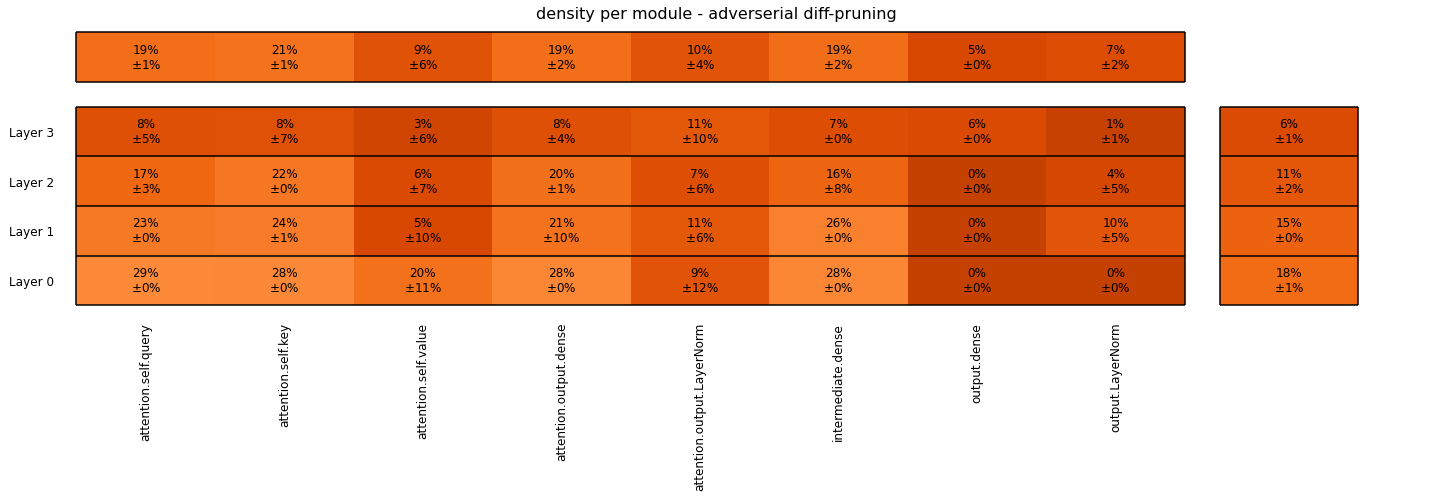

In [8]:
title_fontsize = 16
text_fontsize = 12

plt.figure(figsize=(20,7))
plt.barh(y_coords_adj, width/2, left=0-width/2, height=width, color="w")
start = 0
for m_name in module_names:
    averages, error_margins = zip(*[l[m_name] for l in layer_list])
    m_average, m_error_margin = [ar_to_scalar(ar) for ar in module_dict[m_name]]
    color = [colors[1](color_fn(a)) for a in averages]
    color.append("w")
    color.append(colors[1](color_fn(m_average)))
    plt.barh(y_coords_adj, width, height=width, left=start, color=color)
    for y, a, e in zip(y_coords, averages, error_margins):
        a, e = ar_to_scalar(a), ar_to_scalar(e)
        plt.text(start+width/2, y, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    plt.text(start+width/2, y_coords_adj[-1], "{:.0%}\n$\pm${:.0%}".format(m_average, m_error_margin), ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

plt.barh(y_coords, spacing, left=start, height=width, color="w")
start += spacing

averages, error_margins = zip(*list(layer_dict.values())[1:])
color = [colors[1](color_fn(a)) for a in averages]
plt.barh(y_coords, width, left=start, height=width, color=color)
for y, a, e in zip(y_coords, averages, error_margins):
    a, e = ar_to_scalar(a), ar_to_scalar(e)
    plt.text(start+width/2, y, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions[:-2]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0-width/2, y_coords[-1]+width/2, colors="black")
for x in vline_positions[:2]:
    plt.vlines(x, y_coords_adj[-1]-width/2, y_coords_adj[-1]+width/2, colors="black")

plt.xticks(np.arange(n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)
plt.title("density per module - adverserial diff-pruning", fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=0)
plt.tick_params(axis="y", left=False, pad=-50)

plt.tight_layout()
# plt.savefig(os.path.join(output_folder, "density_per_module_adv.png"))
plt.show()

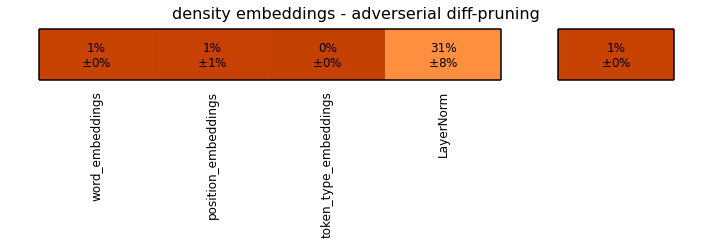

In [9]:
emb_dict = {k[11:]:v for k,v in base_dict.items() if k[:10]=="embeddings"}
n_modules = len(emb_dict)

width = 1
spacing = width / 4
x_coords = np.arange(n_modules, step=width)
x_coords_adj = np.concatenate([x_coords, [x_coords[-1]+spacing+width/2, x_coords[-1]+width*1.5]])
averages, error_margins= zip(*emb_dict.values())
l_average, l_error_margin = np.concatenate(layer_dict[0])
color = [colors[1](color_fn(a)) for a in averages] + ["w", colors[1](color_fn(l_average))]
plt.figure(figsize=(10,3.5))
plt.bar(x_coords_adj, height=width, width=[width] * n_modules + [spacing, width], color=color)
for x, a, e in zip(x_coords, averages, error_margins):
    a, e = ar_to_scalar(a), ar_to_scalar(e)
    plt.text(x, width/2, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
plt.text(x_coords_adj[-1], width/2, "{:.0%}\n$\pm${:.0%}".format(l_average, l_error_margin), ha='center', va='center', color="k", fontsize=text_fontsize)

x_coords_lines = [x_coords[0]-width/2, x_coords[-1]+width/2, x_coords[-1]+width/2+spacing*2, x_coords[-1]+width*1.5+spacing*2]
for y in [0, width]:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, 0, width, colors="black")

plt.bar(0, height=-width, width=width, color="w")

plt.xticks(x_coords, labels=emb_dict.keys(), rotation=90, fontsize=text_fontsize)
plt.yticks([])
plt.title("density embeddings - adverserial diff-pruning", fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-50)

plt.tight_layout()
# plt.savefig(os.path.join(output_folder, "density_embedding_adv.png"))
plt.show()

### Sparsity accross seeds

In [10]:
model_list = []
for seed in range(n_seeds):
    filepath = os.path.join(folder, experiment_name.format(seed))
    m = model_cls.load_checkpoint(filepath)
    model_list.append(m.get_diff_weights(idx=0, as_module=False))

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing B

In [11]:
base_nonzero_dict, layer_nonzero_dict, module_nonzero_dict, layer_module_nonzero_dict = get_nonzero_dicts(model_list)

In [12]:
get_nonzero_pct = lambda x: x[1:] / x[0]

module_nonzero_pct_dict = {k:get_nonzero_pct(v) for k,v in module_nonzero_dict.items()}
layer_nonzero_pct_dict = {k:get_nonzero_pct(v) for k,v in layer_nonzero_dict.items()}
layer_module_nonzero_pct_dict = {k1:{k2:get_nonzero_pct(v) for k2,v in d.items()} for k1,d in layer_module_nonzero_dict.items()}

In [13]:
n_layers = len(layer_nonzero_pct_dict) - 1
n_modules = len(module_nonzero_pct_dict)
module_names = list(module_nonzero_pct_dict.keys())

colors = [plt.get_cmap('Blues'), plt.get_cmap('Oranges')]
color_fn = lambda x: abs(x)

width = 1
spacing = width / 4
y_coords = np.arange(n_layers)
y_coords_adj = np.concatenate([
    y_coords,
    [y_coords[-1] + width, y_coords[-1] + width*1.5]]
)
hline_positions = np.concatenate([
    (y_coords - width/2),
    [y_coords[-1] + width/2, y_coords_adj[-1] - width/2, y_coords_adj[-1] + width/2]
])
vline_positions = [0, width*n_modules, width*n_modules+spacing, width*(n_modules+1)+spacing]

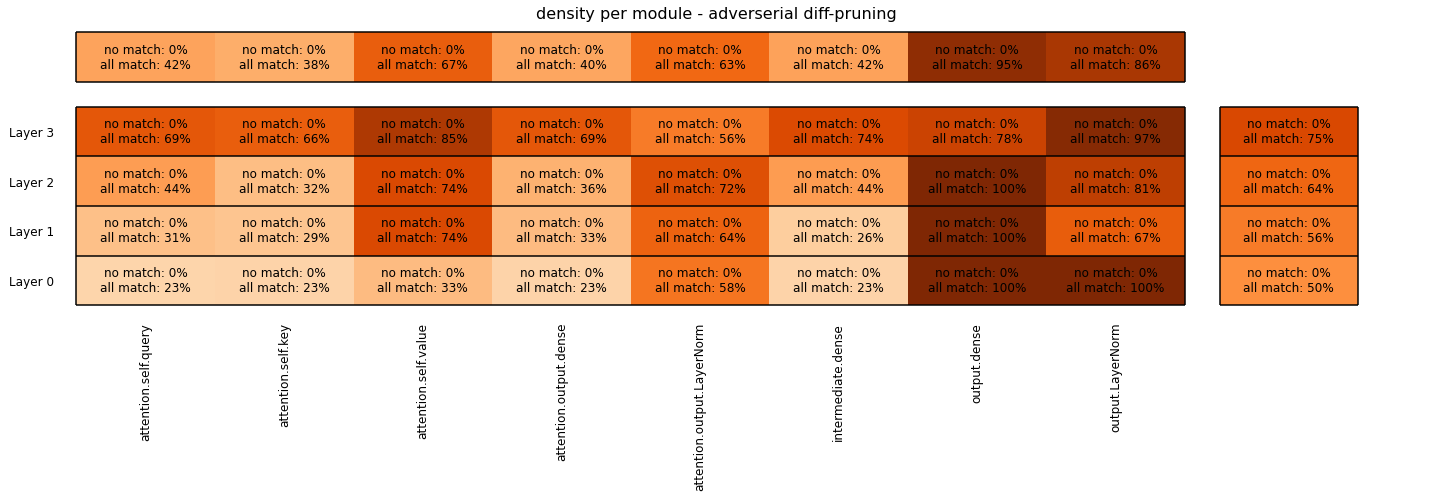

In [14]:
title_fontsize = 16
text_fontsize = 12

plt.figure(figsize=(20,7))
plt.barh(y_coords_adj, width/2, left=0-width/2, height=width, color="w")
start = 0
for m_name in module_names:
    no_matches, all_matches = zip(*[x[m_name][[0,-1]] for x in list(layer_module_nonzero_pct_dict.values())[1:]])
    m_no_match, m_all_match = module_nonzero_pct_dict[m_name][0], module_nonzero_pct_dict[m_name][-1]
    color = [colors[1](color_fn(a)) for a in all_matches]
    color.append("w")
    color.append(colors[1](color_fn(m_all_match)))
    plt.barh(y_coords_adj, width, height=width, left=start, color=color)
    for y, a, e in zip(y_coords, no_matches, all_matches):
        plt.text(start+width/2, y, "no match: {:.0%}\nall match: {:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    plt.text(start+width/2, y_coords_adj[-1], "no match: {:.0%}\nall match: {:.0%}".format(m_no_match, m_all_match), ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

plt.barh(y_coords, spacing, left=start, height=width, color="w")
start += spacing

no_matches, all_matches = zip(*[x[[0,-1]] for x in list(layer_nonzero_pct_dict.values())[1:]])
color = [colors[1](color_fn(a)) for a in all_matches]
plt.barh(y_coords, width, left=start, height=width, color=color)
for y, a, e in zip(y_coords, no_matches, all_matches):
    plt.text(start+width/2, y, "no match: {:.0%}\nall match: {:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions[:-2]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0-width/2, y_coords[-1]+width/2, colors="black")
for x in vline_positions[:2]:
    plt.vlines(x, y_coords_adj[-1]-width/2, y_coords_adj[-1]+width/2, colors="black")

plt.xticks(np.arange(n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)
plt.title("density per module - adverserial diff-pruning", fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=0)
plt.tick_params(axis="y", left=False, pad=-50)

plt.tight_layout()
# plt.savefig(os.path.join(output_folder, "shared_mask_weights_adv.png"))
plt.show()

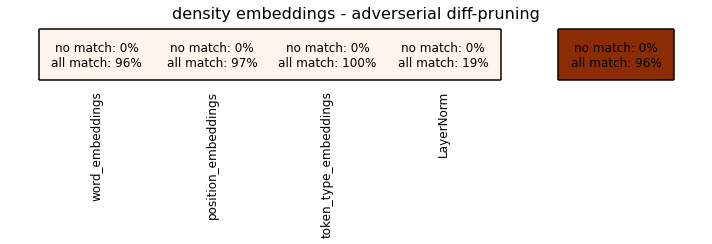

In [15]:
emb_dict = {k:get_nonzero_pct(v) for k,v in layer_module_nonzero_dict[0].items()}
n_modules = len(emb_dict)

width = 1
spacing = width / 4
x_coords = np.arange(n_modules, step=width)
x_coords_adj = np.concatenate([x_coords, [x_coords[-1]+spacing+width/2, x_coords[-1]+width*1.5]])
no_matches, all_matches= zip(*[x[[0,-1]] for x in emb_dict.values()])
l_no_match, l_all_match = layer_nonzero_pct_dict[0][[0,-1]]
color = [colors[1](color_fn(a)) for a in no_matches] + ["w", colors[1](color_fn(l_all_match))]
plt.figure(figsize=(10,3.5))
plt.bar(x_coords_adj, height=width, width=[width] * n_modules + [spacing, width], color=color)
for x, a, e in zip(x_coords, no_matches, all_matches):
    a, e = ar_to_scalar(a), ar_to_scalar(e)
    plt.text(x, width/2, "no match: {:.0%}\nall match: {:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
plt.text(x_coords_adj[-1], width/2, "no match: {:.0%}\nall match: {:.0%}".format(l_no_match, l_all_match), ha='center', va='center', color="k", fontsize=text_fontsize)

x_coords_lines = [x_coords[0]-width/2, x_coords[-1]+width/2, x_coords[-1]+width/2+spacing*2, x_coords[-1]+width*1.5+spacing*2]
for y in [0, width]:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, 0, width, colors="black")

plt.bar(0, height=-width, width=width, color="w")

plt.xticks(x_coords, labels=emb_dict.keys(), rotation=90, fontsize=text_fontsize)
plt.yticks([])
plt.title("density embeddings - adverserial diff-pruning", fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-50)

plt.tight_layout()
# plt.savefig(os.path.join(output_folder, "shared_mask_weights_embedding_adv.png"))
plt.show()